# Regression Comparisons and Bootstrapping

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [4]:
%matplotlib inline

In [18]:
def standardize(anylist):
    '''convert any array of numbers to std units '''
    return (anylist - np.mean(anylist)) / np.std(anylist)

def correlation(df, x, y):
    '''correlation between two columns of a dataframe '''
    return np.mean(standardize(df[x]) * standardize(df[y]))

def slope(df, x, y):
    r = correlation(df, x, y)
    return r * np.std(df[y]) / np.std(df[x])

def intercept(df, x, y):
    a = slope(df, x, y)
    return np.mean(df[y]) - a * np.mean(df[x])

# Evaluating the baby weight prediction model 

## Q3

We know that a typical linear regression line is the one that minimizes mean squared error.

However, this is not the best method of checking the predictive power of a model.

A good model should not only fit the data that it has been exposed to, but should also be able to predict the truly unseen data.

In [4]:
phillybabies = pd.read_csv('/users/elizabeth/downloads/phillybabies.csv')

In [6]:
phillybabies.head()

,count,black,educ,smoke,gestate,weight
0,1,NO,0,YES,40,2898
1,2,YES,0,YES,26,994
2,3,NO,2,NO,38,3977
3,4,NO,2,YES,37,3040
4,5,NO,2,NO,38,3523


In [5]:
import scipy.optimize as opt

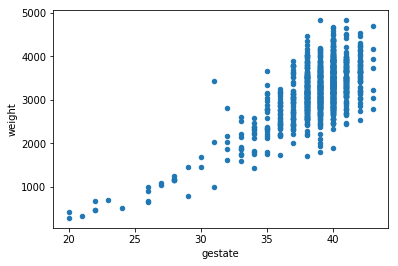

In [6]:
phillybabies.plot.scatter("gestate", "weight")


In [12]:
m, b = np.polyfit(phillybabies["gestate"], phillybabies["weight"], 1)
print("slope:", m)
print("intercept:", b)

slope: 166.44628542785355
intercept: -3245.4463939995358


In [13]:
predicted_weight = phillybabies["gestate"] * m + b
res = phillybabies["weight"] - predicted_weight
rmse = np.sqrt(np.mean(np.power(res, 2)))
print('the root mean squared error: ' + str(rmse))

the root mean squared error: 450.920959539229


In [14]:
def baby_rmse(s):
    x = phillybabies["gestate"]
    y = phillybabies["weight"]
    y_pred = s[0] * x + s[1]
    return np.sqrt(np.mean(y_pred - y)**2)

In [15]:
# using the approximations of the slope and intercept from np.polyfit
opt.minimize(baby_rmse, np.array([166, -3245]))

      fun: 6.472555836432952e-08
 hess_inv: array([[6.29760731e-03, 1.62137069e-04],
       [1.62137069e-04, 1.00066702e+00]])
      jac: array([30.15393822, -1.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 408
      nit: 1
     njev: 99
   status: 2
  success: False
        x: array([  166.43450464, -3244.98881332])

- model that predicts philly baby weights based on gestational days (via opt.minimize model):
      baby weight = -3244.99 + 166.4345 * number of gestational days

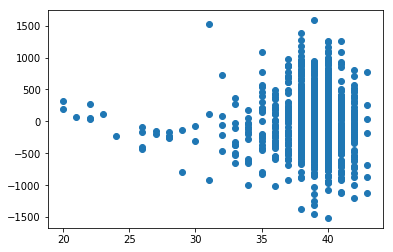

In [16]:
plt.scatter(phillybabies["gestate"], res)

- When we plot the residuals, we want to see not only small residuals centered around 0, but also random-looking residuals. This scatter plot of the residuals does not have a high concentration of points centered around 0, which may be explained by heteroscedasticity. So no, this is not an amazing regression model.

## Making a regression model (removed outliers) to predict a baby's birth weight depending on gestational days

In [19]:
#removing outliers:
phillybabies['standardized_gestate'] = standardize(phillybabies['gestate'])
phillybabies.head()

,count,black,educ,smoke,gestate,weight,standardized_gestate
0,1,NO,0,YES,40,2898,0.433818
1,2,YES,0,YES,26,994,-4.807591
2,3,NO,2,NO,38,3977,-0.314955
3,4,NO,2,YES,37,3040,-0.689341
4,5,NO,2,NO,38,3523,-0.314955


In [20]:
# We're taking out all the rows with gestational week values that are outside of 2 standard deviations from the mean.
# That is how I will define outliers for this problem; data outside 2 STDs from the mean (Arvind said this was ok on 
# piazza)
upper_bound = np.mean(phillybabies['standardized_gestate']) + 2 * np.std(phillybabies['standardized_gestate'])
lower_bound = np.mean(phillybabies['standardized_gestate']) - 2 * np.std(phillybabies['standardized_gestate'])
within_2_SD = phillybabies[np.logical_and(phillybabies['standardized_gestate'] < upper_bound, phillybabies['standardized_gestate'] > lower_bound)]
phillybabies_no_outliers = within_2_SD

In [21]:
predicted_weight_no_outliers = phillybabies_no_outliers["gestate"] * m + b
res = phillybabies_no_outliers["weight"] - predicted_weight_no_outliers

In [22]:
m, b = np.polyfit(phillybabies_no_outliers["gestate"], phillybabies_no_outliers["weight"], 1)
print("slope:", m)
print("intercept:", b)

slope: 153.63563813621548
intercept: -2738.687721479927


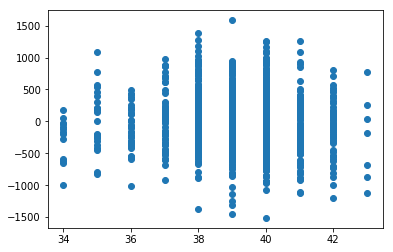

In [23]:
plt.scatter(phillybabies_no_outliers["gestate"], res)

- Yes, removing the outliers makes the model more accurate. Good linear models should residuals that look like a blob on the scatterplot. This is more blobbish than the first scatter plot with the outliers.

## Increasing accuracy via bootstrapping, confidence intervals

Bootstrapping steps:

1. Compute a statistic from the original sample - in this case, the slope of the regression line.
2. Repeatedly create samples from your original sample by sampling with replacement
3. For each of the samples, compute the same statistic and store the values obtained.
4. Finally, plot a histogram of the various values of the statistic.

In [24]:
babies = pd.read_csv('/users/elizabeth/downloads/baby.csv')

In [26]:
original_slope = slope(babies,'Gestational Days', 'Birth Weight')
original_slope

0.4665568769492164

In [27]:
random_sample = babies.sample(500, replace=True)  
slope(random_sample, 'Gestational Days', 'Birth Weight')

0.5096112246823102

In [28]:
slopes = []
for i in np.arange(2500): #for 2500 times, we want to generate random sample w/ replacement
    random_sample = babies.sample(500, replace=True)  
    new_slope = slope(random_sample, 'Gestational Days', 'Birth Weight')
    slopes.append(new_slope)

Text(0.5,1,'Bootstrapped Slope Distribution')

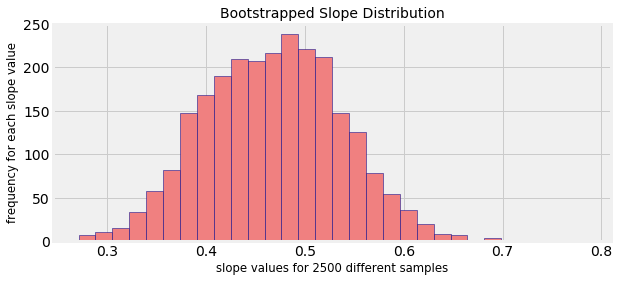

In [29]:
plt.figure(figsize=(10,4))
plt.style.use('fivethirtyeight')
plt.hist(slopes, bins = 30, color = 'lightcoral', ec = 'darkblue')
plt.xlabel('slope values for 2500 different samples', size = 'small')
plt.ylabel('frequency for each slope value', size = 'small')
plt.title('Bootstrapped Slope Distribution', size = 'medium')

In [30]:
# Calculating a 95% confidence interval for the slope values
lower_bound = np.percentile(slopes, 2.5)
upper_bound = np.percentile(slopes, 97.5)

In [170]:
print("We are 95% certain that the slope values will be between " + str(lower_bound) + " and " + str(upper_bound))

We are 95% certain that the slope values will be between 0.3366879560493333 and 0.610212628551802


## Movies: Comparing Rotten Tomatoes scores and IMDB scores

In [31]:
movies = pd.read_csv('/users/elizabeth/downloads/blockbusters.csv')

In [32]:
movies.columns

Index(['audience_freshness', 'poster_url', 'rt_audience_score', 'rt_freshness',
       'rt_score', '2015_inflation', 'adjusted', 'genres', 'Genre_1',
       'Genre_2', 'Genre_3', 'imdb_rating', 'length', 'rank_in_year', 'rating',
       'release_date', 'studio', 'title', 'worldwide_gross', 'year'],
      dtype='object')

In [33]:
# dropping any possible nans in the listed subset; not dropping nans in 'Genre_1', 'Genre_2', and 'Genre_3'
# because that would remove movies that don't have more than 1 genre.
movies = movies.dropna(subset = ['imdb_rating', 'length', 'rank_in_year', 'genres', 'rating', 'year', 
                                 'audience_freshness', 'rt_audience_score', 'rt_freshness','rt_score',
                                 'worldwide_gross'])

In [34]:
movies.shape

(398, 20)

In [35]:
# Removing all the movies with rt_scores and rt_freshness ratings of 0. 
movies = movies[np.logical_and(movies['rt_score'] != 0, movies['rt_freshness'] != 0)]
movies.shape

(392, 20)

#### Are the rt_freshness scores and the imdb scores related in any manner?

In [36]:
r = correlation(movies, 'rt_freshness', 'imdb_rating')
r

0.7379022733512594

- there is a distinct positive correlation between rt freshness and imdb scores.

In [37]:
m, b = np.polyfit(movies['rt_freshness'], movies['imdb_rating'], 1)

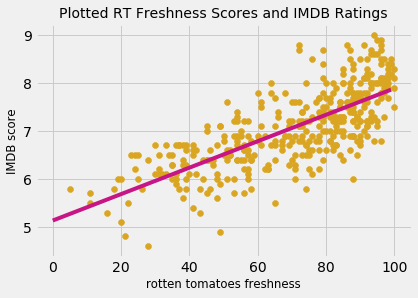

In [38]:
plt.style.use('fivethirtyeight')

plt.figure(figsize = (6, 4))
plt.scatter(movies['rt_freshness'], movies['imdb_rating'], color = 'goldenrod')
plt.xlabel('rotten tomatoes freshness', size = 'small')
plt.ylabel('IMDB score', size = 'small')
plt.title('Plotted RT Freshness Scores and IMDB Ratings', size = 'medium')

xvals = np.arange(0, 100)
yvals = m * xvals + b 
plt.plot(xvals, yvals, color = 'mediumvioletred') #graphing the linear regression


- The correlation of 0.7379 and the scatter plot show there is some significnt relation between rt freshness and imdb scores.

#### Identifying outliers (in the sense that their rotten tomatoes score and their imdb score are vastly different)

In [39]:
# standardizing the ratings.
movies['z_rt_freshness'] = standardize(movies['rt_freshness'])
movies['z_imdb_rating'] = standardize(movies['imdb_rating'])

In [40]:
# calculating the difference between rt freshness and imdb rating for all rows
movies['rt_imdb_difference'] = movies['z_rt_freshness'] - movies['z_imdb_rating']
movies['rt_imdb_difference'] = np.abs(movies['rt_imdb_difference'])
movies.sort_values('rt_imdb_difference', ascending = False)[['rt_imdb_difference', 'title']].head(5)

,rt_imdb_difference,title
344,2.138767,Private Benjamin
202,2.056177,Forrest Gump
3,1.932724,Interstellar
279,1.739681,Three Men and a Baby
48,1.697196,The Twilight Saga: Eclipse


In [41]:
top_outliers = movies.sort_values('rt_imdb_difference', ascending = False)[['rt_imdb_difference', 'title']].head(5)[['title']]
print('These are the 5 movies with the greatest difference between RT score and IMDB score:')
top_outliers

These are the 5 movies with the greatest difference between RT score and IMDB score:


,title
344,Private Benjamin
202,Forrest Gump
3,Interstellar
279,Three Men and a Baby
48,The Twilight Saga: Eclipse


Question: if you had to use only one out of the rotten tomatoes or imdb scores to predict the success of a movie, which one would you pick? 

To answer this, I build a linear regression model that predicts the adjusted gross based only on rt_freshness. Then I build a linear regression model that predicts the adjusted gross based on imdb scores. Then I will evaluate the models by comparing the root mean square error in the predictions.

In [42]:
# Must write a function to convert the values from strings to floats
def floatify(my_number):
    my_num = my_number.split('$')
    my_num = my_num[1].split(',')
    my_num = float(''.join(my_num))
    return my_num

vect_floatify = np.vectorize(floatify)

In [43]:
movies['float_gross'] = vect_floatify(movies['adjusted'])

In [44]:
# making the model for gross based on RT freshness

In [45]:
m1, b1 = np.polyfit(movies["rt_freshness"], movies["float_gross"], 1)
print("slope:", m1)
print("intercept:", b1)

slope: 1063836.260672998
intercept: 471601530.01662207


In [46]:
correlation(movies, 'float_gross', 'rt_freshness')

0.06770861431189738

- very small linear correlation between rt freshness and gross earnings.

##### linear regression model that predicts the adjusted gross based only on rt_freshness

- predicted_gross_rt = rt_freshness * 1063836.261 + 471601530.017

In [47]:
# making the model for gross based on IMDB ratings

In [48]:
m2, b2 = np.polyfit(movies["imdb_rating"], movies["float_gross"], 1)
print("slope:", m2)
print("intercept:", b2)

slope: 110195939.90135102
intercept: -233234549.55004466


In [49]:
correlation(movies, 'float_gross', 'imdb_rating')

0.26214030911798475

- small linear correlation between rt freshness and gross earnings.

##### linear regression model that predicts the adjusted gross based on imdb scores

- predicted_gross_imdb = imdb_rating * 110195939.901  - 233234549.550

####  evaluate the models by comparing the root mean square error in the predictions.

In [50]:
predicted_gross_rt = (movies["rt_freshness"] * m1) + b1
res_rt = movies["float_gross"] - predicted_gross_rt #actual gross - predicted gross based on rt_freshness
mse_rt = np.mean(np.power(res_rt, 2))
rmse_rt = np.sqrt(mse_rt)
print('This is the RMSE for the rotten-tomatoes-based prediction: ' + str(rmse_rt))

This is the RMSE for the rotten-tomatoes-based prediction: 339730351.2002244


In [51]:
predicted_gross_imdb = (movies["imdb_rating"] * m2) + b2
res_imdb = movies["float_gross"] - predicted_gross_imdb #actual gross - predicted gross based on imdb_freshness
mse_imdb = np.mean(np.power(res_imdb, 2))
rmse_imdb = np.sqrt(mse_imdb)
print('This is the RMSE for the IMDB-based prediction: ' + str(rmse_imdb))

This is the RMSE for the IMDB-based prediction: 328604003.56867945


In [52]:
rmse_imdb < rmse_rt

True

- We can see that the RMSE for the IMDB-based prediction of movie gross is less than the RMSE for the Rotten Tomatoes-based prediction of movie gross. Thus the IMDB-based prediction does a better job at predicting the gross of a movie.

### Movie budgets affecting gross earnings?

In [56]:
budgets = pd.read_csv('/users/elizabeth/downloads/budgets.csv')

In [57]:
movies = movies.rename(columns = {'title' : 'Movie Title'})
budgets = budgets.rename(columns = {'Movie' : 'Movie Title'})

In [58]:
movie_budgets = pd.merge(movies, budgets, on = 'Movie Title', how = 'inner')

In [59]:
movie_budgets.head()

,audience_freshness,poster_url,rt_audience_score,rt_freshness,rt_score,2015_inflation,adjusted,genres,Genre_1,Genre_2,...,worldwide_gross,year,z_rt_freshness,z_imdb_rating,rt_imdb_difference,float_gross,Release Date,Production Budget,Domestic Gross,Worldwide Gross
0,92.0,http://resizing.flixster.com/gxRJwetP1eNIrPR6x...,4.3,89.0,7.5,-0.26%,"$712,903,691.09",Sci-Fi\nAdventure\nAction,Sci-Fi,Adventure,...,"$714,766,572.00",2014.0,0.856221,0.893455,0.037234,7.129037e+08,4/4/14,"$170,000,000","$259,746,958","$714,401,889"
1,89.0,http://resizing.flixster.com/gDtbA1iPxTYEjBZeS...,4.2,90.0,7.9,-0.26%,"$706,988,165.89",Sci-Fi\nDrama\nAction,Sci-Fi,Drama,...,"$708,835,589.00",2014.0,0.902363,0.770003,0.132360,7.069882e+08,7/11/14,"$170,000,000","$208,545,589","$710,644,566"
2,93.0,http://resizing.flixster.com/YrF_OeTQx3bXNsMLI...,4.4,91.0,7.7,-0.26%,"$772,158,880.00",Sci-Fi\nAdventure\nAction,Sci-Fi,Adventure,...,"$774,176,600.00",2014.0,0.948506,1.263813,0.315307,7.721589e+08,8/1/14,"$170,000,000","$333,172,112","$771,051,335"
3,86.0,http://resizing.flixster.com/l9yjA-72sZMYECeOj...,4.2,72.0,7.0,-0.26%,"$671,220,455.10",Sci-Fi\nAdventure,Sci-Fi,Adventure,...,"$672,974,414.00",2014.0,0.071803,2.004527,1.932724,6.712205e+08,11/5/14,"$165,000,000","$188,017,894","$667,752,422"
4,71.0,http://resizing.flixster.com/YukULOFULUesVZccN...,3.8,49.0,5.7,-0.26%,"$756,677,675.77",Family\nAdventure\nAction,Family,Adventure,...,"$758,654,942.00",2014.0,-0.989469,0.029288,1.018757,7.566777e+08,5/30/14,"$180,000,000","$241,407,328","$758,536,735"


In [60]:
movie_budgets['float_production_budget'] = vect_floatify(movie_budgets['Production Budget'])

In [61]:
original_correlation = correlation(movie_budgets,'float_production_budget', 'float_gross')
original_correlation

0.491425439312412

In [62]:
random_sample = movie_budgets.sample(500, replace=True)  
correlation(random_sample,'float_production_budget', 'float_gross')

0.4753803073237066

In [63]:
correlations = []
for i in np.arange(2500): #for 2500 times, we want to generate random sample w/ replacement
    random_sample = movie_budgets.sample(500, replace=True)   
    new_correlations = correlation(random_sample,'float_production_budget', 'float_gross')
    correlations.append(new_correlations)

Text(0.5,1,'Bootstrapped Correlation Distribution (gross sales by budget)')

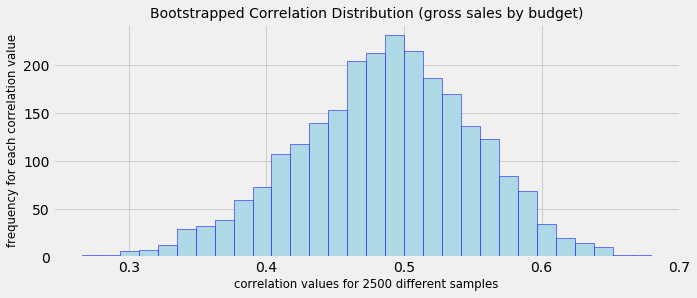

In [64]:
plt.figure(figsize=(10,4))
plt.style.use('fivethirtyeight')
plt.hist(correlations, bins = 30, color = 'lightblue', ec = 'blue')
plt.xlabel('correlation values for 2500 different samples', size = 'small')
plt.ylabel('frequency for each correlation value', size = 'small')
plt.title('Bootstrapped Correlation Distribution (gross sales by budget)', size = 'medium')

In [65]:
# Calculating a 95% confidence interval for the correlation values
lower_bound = np.percentile(correlations, 2.5)
upper_bound = np.percentile(correlations, 97.5)

In [66]:
print("We are 95% certain that the correlation values will be between " + str(lower_bound) + " and " + str(upper_bound))

We are 95% certain that the correlation values will be between 0.35032017724543363 and 0.6045847101183042


#### Based on this confidence interval, is movie budget a good predictor for the amount of money that a movie will make?

- Yes. We are 95% certain that the correlation coefficient between the movie budget and its gross earnings would be between 0.351 and 0.605, and any correlation coefficient greater than 0.3 is at least a moderately strong indication of a positive linear relationship. So the movie budget is a relatively good indicator of the amount of money that it will make.